## Boilerplate

In [1]:
import sys
import subprocess
import os
import json
from pathlib import Path

if 'google.colab' in sys.modules:
    print("Running on Colab")

    subprocess.run([
        'git', 'clone', 'https://github.com/walligot/don_thesis.git'
    ])

    os.chdir('/content/don_thesis')
    #%pip install git+https://github.com/mitchellostrow/DSA.git
    %pip install git+https://github.com/Melina-Jingting/foundational_ssm.git

    from google.colab import drive
    drive.mount('/content/drive')

    os.environ['HOME'] = '/content/drive/MyDrive/Thesis'
    ROOT_PATH = '/content/don_thesis'
    os.environ['ROOT_PATH'] = ROOT_PATH

    wandb_config_path = '/content/drive/MyDrive/Colab/wandb.config.json'

else:
    #%pip install git+https://github.com/mitchellostrow/DSA.git

    current_path = Path().resolve()
    ROOT_PATH = None
    for parent in [current_path] + list(current_path.parents):
        if "don_thesis" in parent.name.lower():
            ROOT_PATH = parent
            os.environ['ROOT_PATH'] = str(ROOT_PATH)
            break

    if not ROOT_PATH:
        raise FileNotFoundError("Directory with name 'don_thesis' not found.")

    print("Running locally or elsewhere")
    wandb_config_path = os.path.join(os.environ['ROOT_PATH'], 'config', 'wandb.config.json')

# Set WANDB_CONFIG_PATH
os.environ['WANDB_CONFIG_PATH'] = wandb_config_path

# Load API key from JSON
with open(wandb_config_path) as f:
    config = json.load(f)
    os.environ['WANDB_API_KEY'] = config['WANDB_API_KEY']

%pip install pynwb
%pip install equinox
#%pip install equinox==0.12.2 jax==0.7.0 jaxlib==0.7.0

sys.path.append('/content/don_thesis/src')
print(f"Root path: {ROOT_PATH}")
print(f"WANDB config path: {wandb_config_path}")

Running on Colab
  Cloning https://github.com/Melina-Jingting/foundational_ssm.git to /tmp/pip-req-build-fmbkdzv3
  Running command git clone --filter=blob:none --quiet https://github.com/Melina-Jingting/foundational_ssm.git /tmp/pip-req-build-fmbkdzv3
  Resolved https://github.com/Melina-Jingting/foundational_ssm.git to commit 0946f85db8cb835434ac12f50e22c187e8824699
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

## Load Data

### Model Checkpoints

In [2]:
import wandb
import equinox as eqx
import os

# Foundational SSM imports
from omegaconf import OmegaConf
import tempfile
from foundational_ssm.models import SSMDownstreamDecoder

import wandb
import equinox as eqx
import os

# Foundational SSM imports
from omegaconf import OmegaConf
import tempfile
from foundational_ssm.models import SSMDownstreamDecoder, SSMFoundationalDecoder
from foundational_ssm.utils import h5_to_dict
from foundational_ssm.transform import smooth_spikes
import jax
import jax.numpy as jnp
import numpy as np
from typing import Any, BinaryIO

def load_model_and_state_from_checkpoint_wandb_old(artifact_full_name, model_cls=SSMDownstreamDecoder):
    """Load model, optimizer state, epoch, and step from a checkpoint file."""
    api = wandb.Api()
    try:
        artifact = api.artifact(artifact_full_name, type="checkpoint")
    except Exception as e:
        raise FileNotFoundError(f"Could not find checkpoint artifact: {artifact_full_name}")

    run = artifact.logged_by()
    run_cfg = OmegaConf.create(run.config)
    model_cfg = OmegaConf.create(run_cfg.model)
    model_template, state_template = eqx.nn.make_with_state(model_cls)(
        **model_cfg,
    )

    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        model = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "model.ckpt"), model_template)
        state = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "state.ckpt"), state_template)

    meta = artifact.metadata
    return model, state, meta

def default_deserialise_filter_spec(f: BinaryIO, x: Any) -> Any:
    """Default filter specification for deserialising saved data.

    **Arguments**

    -   `f`: file-like object
    -   `x`: The leaf for which the data needs to be loaded.

    **Returns**

    The new value for datatype `x`.

    !!! info

        This function can be extended to customise the deserialisation behaviour for
        leaves.

    !!! example

        Skipping loading of jax.Array.

        ```python
        import jax.numpy as jnp
        import equinox as eqx

        tree = (jnp.array([4,5,6]), [1,2,3])
        new_filter_spec = lambda f,x: (
            x if isinstance(x, jax.Array) else eqx.default_deserialise_filter_spec(f, x)
        )
        new_tree = eqx.tree_deserialise_leaves("some_filename.eqx", tree, filter_spec=new_filter_spec)
        ```
    """  # noqa: E501
    try:
        if isinstance(x, (jax.Array, jax.ShapeDtypeStruct)):
            return jnp.load(f)
        elif isinstance(x, np.ndarray):
            # Important to use `np` here to avoid promoting NumPy arrays to JAX.
            return np.load(f)
        elif eqx.is_array_like(x):
            # np.generic gets deserialised directly as an array, so convert back to a scalar
            # type here.
            # See also https://github.com/google/jax/issues/17858
            out = np.load(f)
            if isinstance(x, jax.dtypes.bfloat16):
                out = out.view(jax.dtypes.bfloat16)
            if np.size(out) == 1:
                return type(x)(out.item())
        else:
            return x
    except:
        print("Failed to load data for leaf with shape/ value:", x.shape if hasattr(x, 'shape') else x)
        return x

def load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMDownstreamDecoder, model_cfg=None):
    """Load model, optimizer state, epoch, and step from a checkpoint file."""
    api = wandb.Api()
    try:
        artifact = api.artifact(artifact_full_name, type="checkpoint")
    except Exception as e:
        raise FileNotFoundError(f"Could not find checkpoint artifact: {artifact_full_name}")

    if model_cfg is None:
        run = artifact.logged_by()
        run_cfg = OmegaConf.create(run.config)
        print(run_cfg)
        model_cfg = OmegaConf.create(run_cfg.model)

    model_template, state_template = eqx.nn.make_with_state(model_cls)(
        **model_cfg
    )

    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        model = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "model.ckpt"), model_template, default_deserialise_filter_spec)
        state = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "state.ckpt"), state_template, default_deserialise_filter_spec)

    meta = artifact.metadata
    model = eqx.nn.inference_mode(model)
    return model, state, meta

# rtt task models
layer = "2"
pretrain_mode = "scratch"
train_mode = "all"
#alias = "latest" # can be latest/best/ epoch_{any value in range(0,1000,100)}
# epoch 0 now stores a fresh model.
artifact_full_name_trained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:best"
artifact_full_name_untrained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:epoch_0"
rtt_2block_model, trained_state, trained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_trained)
rtt_2block_untrained_model, untrained_state, untrained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_untrained)

layer = "4"
artifact_full_name_trained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:best"
artifact_full_name_untrained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:epoch_0"
#rtt_4block_model, trained_state, trained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_trained)
#rtt_4block_untrained_model, untrained_state, untrained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_untrained)

model = "l2"
#dataset = "similar_task"
#dataset = "reaching_normalized"
dataset = "reaching"
#alias = "best"
alias = "latest"

# Foundational Models
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_2block_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

alias = "epoch_0"
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_2block_untrained_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

model = "l4"
#alias = "best"
alias = "latest"
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_4block_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

alias = "epoch_0"
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_4block_untrained_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: davekk (davekk-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'training.from_scratch': True}

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2_no_context.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prep

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2_no_context.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prep

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.01, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 4, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l4.yaml', 'optimizer': {'lr': 0.001, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_history

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.01, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 4, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l4.yaml', 'optimizer': {'lr': 0.001, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_history

wandb:   3 of 3 files downloaded.  


### Load Activations

In [3]:
import jax

FOUND_2BLOCK_KEYS = [
    #'neural_input_raw', 'neural_input',
    'post_encoder', 'post_encoder_raw',
    'ssm_x_0','ssm_y_0', 'ssm_post_glu_0',
    'ssm_x_1','ssm_y_1', 'ssm_post_glu_1',
]

FOUND_4BLOCK_KEYS = FOUND_2BLOCK_KEYS + [
    'ssm_x_2','ssm_y_2', 'ssm_post_glu_2',
    'ssm_x_3','ssm_y_3', 'ssm_post_glu_3',
]

F_2_TARGETS = ['targets'] + FOUND_2BLOCK_KEYS
F_4_TARGETS = ['targets'] + FOUND_4BLOCK_KEYS

def load_activation_dict(path):
    """
    Loads a nested activations dict saved with np.savez where:
      - Outer keys are dataset IDs (saved as strings)
      - Inner values are dicts with keys like 'ssm_pre_activation_0', etc.
    Returns:
      dict[int, dict[str, np.ndarray]]
    """
    loaded = np.load(path, allow_pickle=True)
    return {
        int(k): {ik: np.array(iv) for ik, iv in v.item().items()}
        for k, v in loaded.items()
    }

def load_activation_dict_rtt(path):
    """
    Loads a nested activations dict saved with np.savez where:
      - Outer keys are dataset IDs (saved as strings)
      - Inner values are dicts with keys like 'ssm_pre_activation_0', etc.
    Returns:
      dict[int, dict[str, np.ndarray]]
    """
    loaded = np.load(path, allow_pickle=True)
    return {
        55: {ik: np.array(iv) for ik, iv in v.item().items()}
        for k, v in loaded.items()
    }

def blend_and_normalise_np(model, d1, d2, norm_keys, insert_key="neural_input_raw", axis=1, eps=1e-8):
    """
    For each outer key in d1:
      - insert d2[key][insert_key] as `insert_key`
      - z-normalise each key in `norm_keys` along `axis`
    Returns a new blended dict (does not mutate d1/d2).
    """
    out = {}
    for k, inner1 in d1.items():
        inner = dict(inner1)  # shallow copy of inner dict
        inner[insert_key] = np.asarray(d2[k][insert_key])
        #print(model.encoders[k].shape)
        #print(inner['neural_input'].shape)
        encode_t = jax.vmap(model.encoders[k], in_axes=0)  # over time
        encode_bt = jax.vmap(encode_t, in_axes=0)
        inner['post_encoder_raw'] = encode_bt(np.asarray(d2[k]['neural_input_raw']))
        inner['post_encoder'] = encode_bt(inner['neural_input'])

        for nk in norm_keys:
            if nk in inner:
                x = np.asarray(inner[nk], dtype=np.float32)
                if x.ndim <= axis:
                    raise ValueError(f"{nk} for outer key {k} has ndim={x.ndim}, cannot normalise along axis={axis}.")
                m = x.mean(axis=axis, keepdims=True)
                s = x.std(axis=axis, ddof=0, keepdims=True)
                inner[nk] = (x - m) / np.maximum(s, eps)

        out[k] = inner
    return out

def blend_and_normalise_np_rtt(model, d1, norm_keys, insert_key="neural_input_raw", axis=1, eps=1e-8):
    """
    For each outer key in d1:
      - insert d2[key][insert_key] as `insert_key`
      - z-normalise each key in `norm_keys` along `axis`
    Returns a new blended dict (does not mutate d1/d2).
    """
    out = {}
    for k, inner1 in d1.items():
        inner = dict(inner1)  # shallow copy of inner dict
        #inner[insert_key] = np.asarray(d2[k][insert_key])
        #print(model.encoders[k].shape)
        #print(inner['neural_input'].shape)
        encode_t = jax.vmap(model.encoder, in_axes=0)  # over time
        encode_bt = jax.vmap(encode_t, in_axes=0)
        inner['post_encoder_raw'] = encode_bt(inner['neural_input_raw'])
        inner['post_encoder'] = encode_bt(inner['neural_input'])

        for nk in norm_keys:
            if nk in inner:
                x = np.asarray(inner[nk], dtype=np.float32)
                if x.ndim <= axis:
                    raise ValueError(f"{nk} for outer key {k} has ndim={x.ndim}, cannot normalise along axis={axis}.")
                m = x.mean(axis=axis, keepdims=True)
                s = x.std(axis=axis, ddof=0, keepdims=True)
                inner[nk] = (x - m) / np.maximum(s, eps)

        out[k] = inner
    return out

#loaded = np.load("/content/drive/MyDrive/Thesis/data/activations20250815.npz", allow_pickle=True)



In [4]:
foundational_2block_data = load_activation_dict("/content/drive/MyDrive/Thesis/data/activations_reaching_2block_20250910_1.npz")
#foundational_4block_data = load_activation_dict("/content/drive/MyDrive/Thesis/data/activations_f_4block_20250830_2.npz")
foundational_input_raw = load_activation_dict("/content/drive/MyDrive/Thesis/data/f_input_raw_20250910_1.npz")

foundational_2block_data = blend_and_normalise_np(foundational_2block_model, foundational_2block_data, foundational_input_raw, norm_keys=[])
#foundational_4block_data = blend_and_normalise_np(foundational_4block_model, foundational_4block_data, foundational_input_raw, norm_keys=[])

## GLU Analysis

In [5]:
from neuralencoder.components import compute_gate_masks_by_context
from foundational_ssm.constants.constants import DATASET_IDX_TO_GROUP, DATASET_IDX_TO_GROUP_SHORT

#loaded = np.load("/content/drive/MyDrive/Thesis/data/activations20250815.npz", allow_pickle=True)
#by_context = load_activation_dict("/content/drive/MyDrive/Thesis/data/activationsreaching20250817.npz")

data_keys=[0, 3, 7, 8, 1, 2, 5, 6]
encoder_labels = [DATASET_IDX_TO_GROUP_SHORT[i] for i in data_keys]

block_id = 0

ctx_ids_0, meanG_0, stdG_0, openM_0, closedM_0 = compute_gate_masks_by_context(
    model=foundational_2block_model,
    by_context=foundational_2block_data,
    block_idx=block_id, gate_path="w2",
    x_key=f"ssm_y_{block_id}",
    open_rule=("thr", 0.7),    # or ('q', 0.7) for top 30% per context
    closed_rule=("thr", 0.3),
    ctx_ids=data_keys,
)

block_id = 1

ctx_ids_1, meanG_1, stdG_1, openM_1, closedM_1 = compute_gate_masks_by_context(
    model=foundational_2block_model,
    by_context=foundational_2block_data,
    block_idx=block_id, gate_path="w2",
    x_key=f"ssm_y_{block_id}",
    open_rule=("thr", 0.7),    # or ('q', 0.7) for top 30% per context
    closed_rule=("thr", 0.3),
    ctx_ids=data_keys,
)

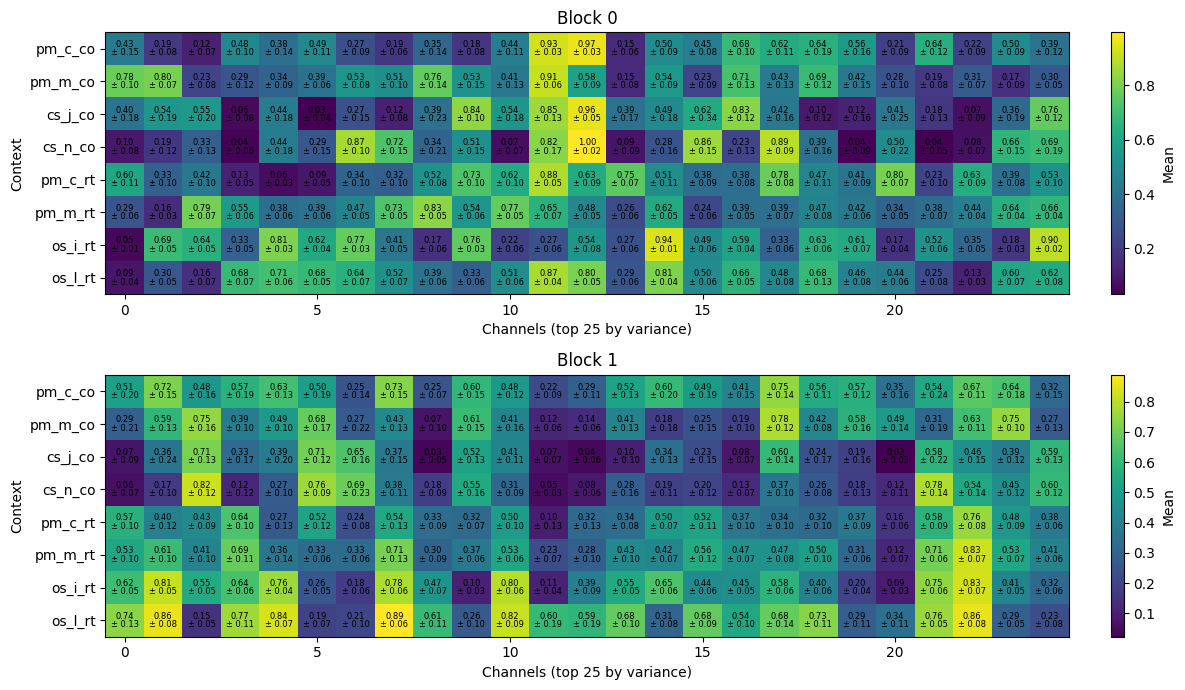

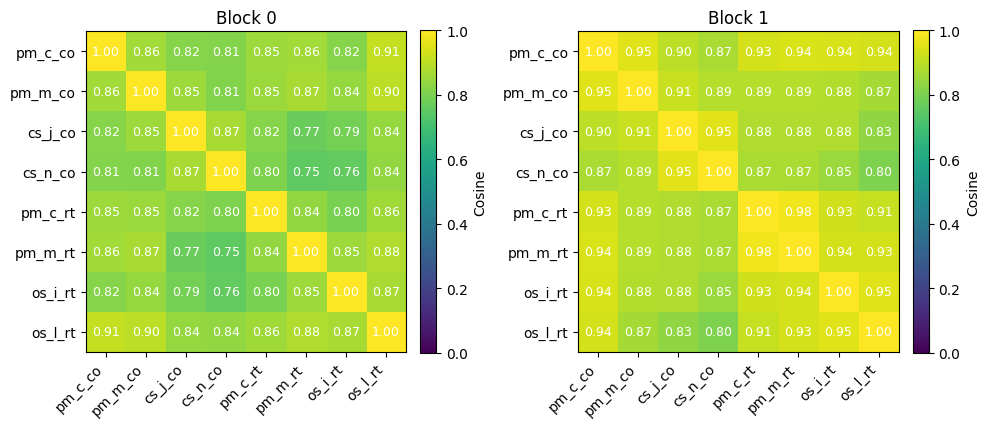

In [7]:
from neuralencoder.components import plot_gate_states_heatmap_stacked, plot_gate_cosine_stacked
fig1, ax1 = plot_gate_states_heatmap_stacked([ctx_ids_0, ctx_ids_1], [meanG_0, meanG_1], [stdG_0, stdG_1], [openM_0, openM_1], [closedM_0, closedM_1]
                                     , top_cols=25, ctx_labels=encoder_labels, title=f"", show_numbers=True, colour='heatmap', subplot_titles=['Block 0', 'Block 1'])

fig3, ax3 = plot_gate_cosine_stacked([ctx_ids_0, ctx_ids_1], [meanG_0, meanG_1], title=f"", ctx_labels=encoder_labels, subplot_titles=['Block 0', 'Block 1'])

## Eigenvalue Plotting

(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Untrained'}, ylabel='A bar block 0\nImag'>,
         <Axes: title={'center': 'Trained'}>],
        [<Axes: xlabel='Real', ylabel='A bar block 1\nImag'>,
         <Axes: xlabel='Real'>]], dtype=object))

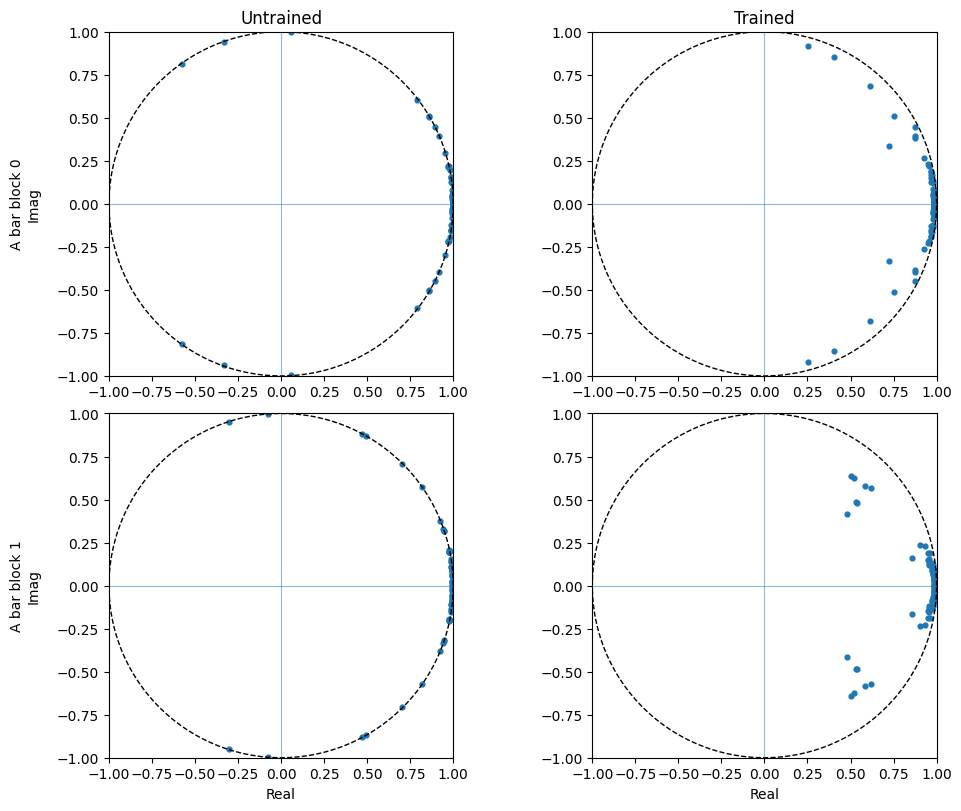

In [3]:
from neuralencoder.components import get_discrete_A_matrix, plot_eig_spectra_grid

untrained_A = [get_discrete_A_matrix(foundational_2block_untrained_model, block_id) for block_id in [0, 1]]
trained_A = [get_discrete_A_matrix(foundational_2block_model, block_id) for block_id in [0, 1]]
row_labels = ["A bar block 0", "A bar block 1"]

plot_eig_spectra_grid(untrained_A, trained_A, row_labels)

## Encoder Comparison

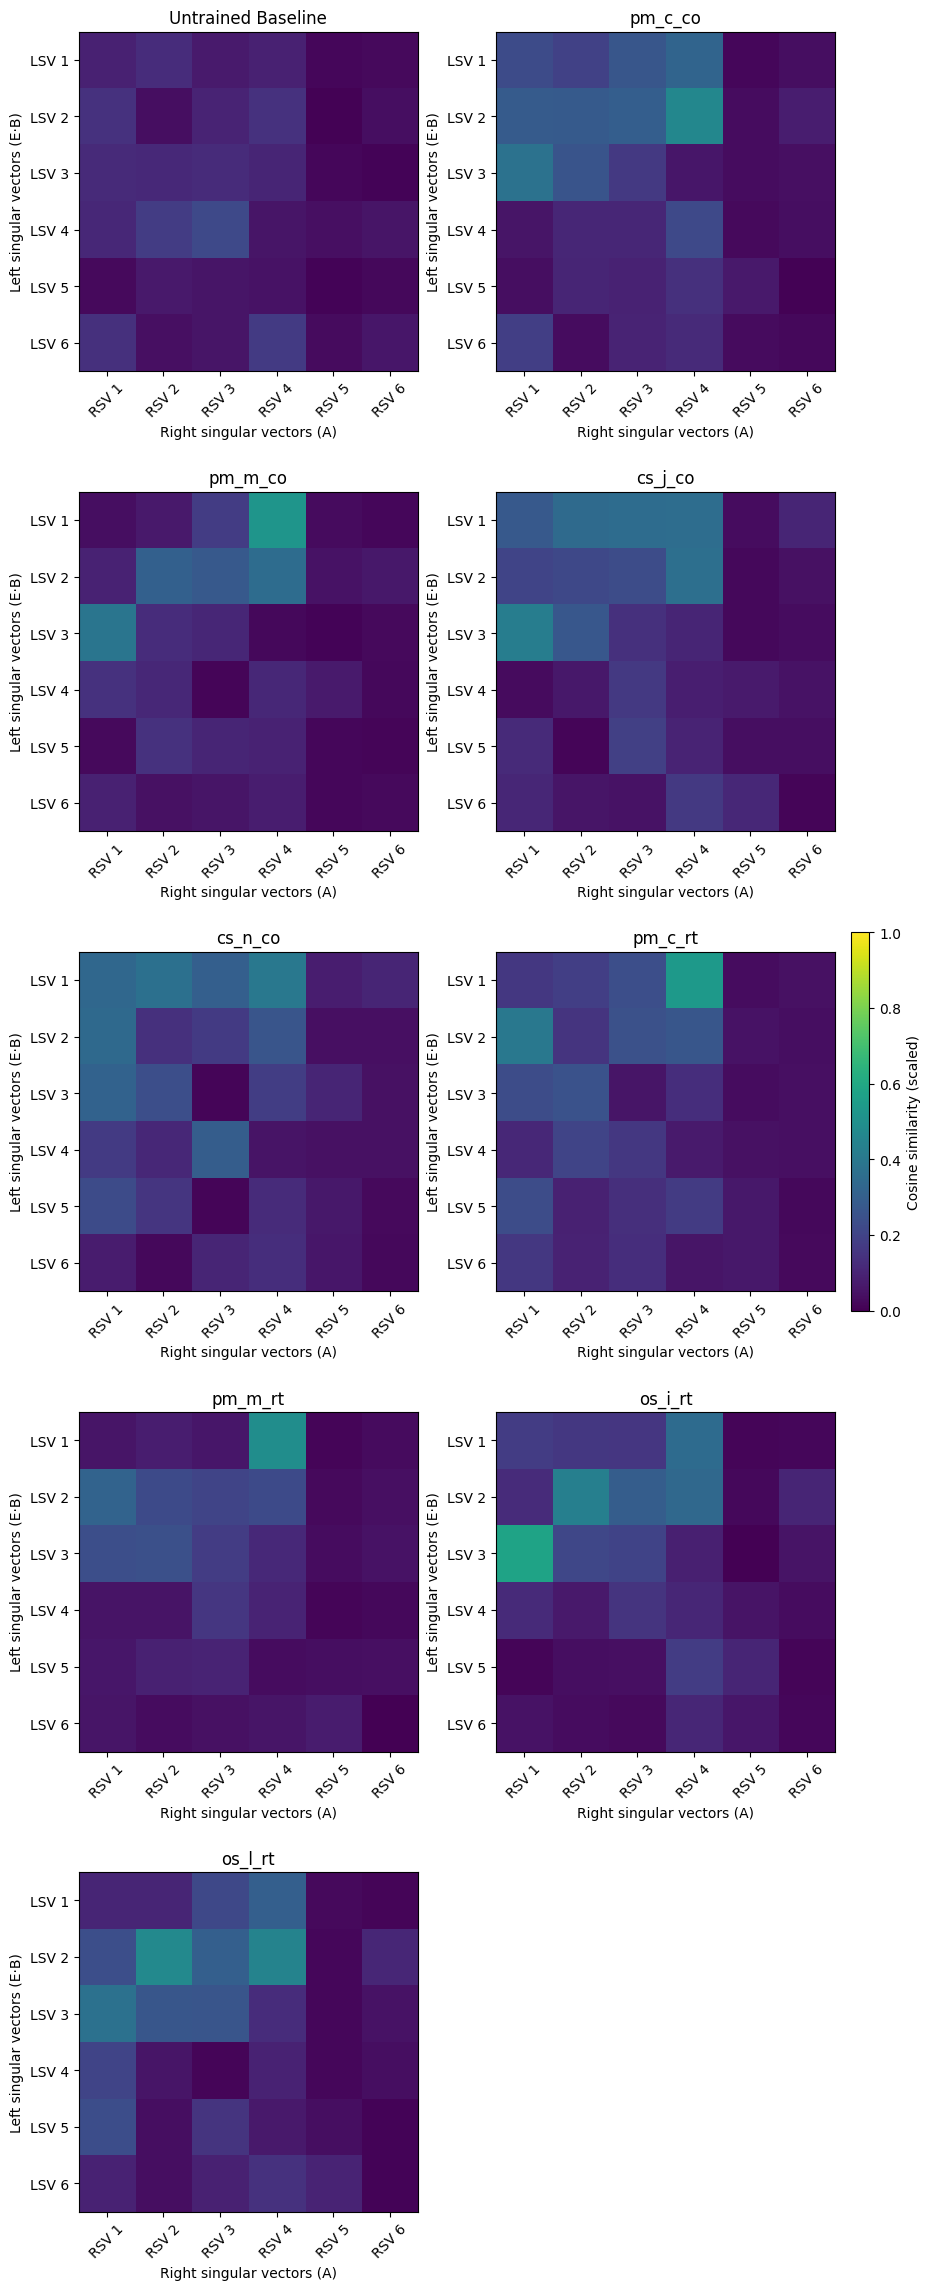

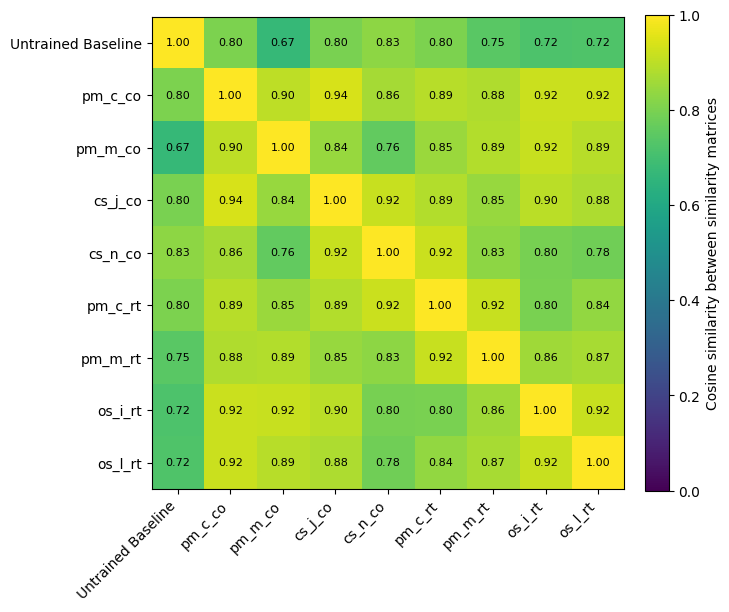

array([[1.        , 0.80448675, 0.66910338, 0.79980834, 0.83027706,
        0.80379337, 0.74573635, 0.72018888, 0.7232698 ],
       [0.80448675, 1.        , 0.89961352, 0.93988095, 0.86434513,
        0.89080795, 0.88146223, 0.92145781, 0.91963793],
       [0.66910338, 0.89961352, 1.        , 0.84438032, 0.7578952 ,
        0.84836446, 0.88622379, 0.91554207, 0.89213138],
       [0.79980834, 0.93988095, 0.84438032, 1.        , 0.91599938,
        0.88597245, 0.84658484, 0.89553351, 0.87868715],
       [0.83027706, 0.86434513, 0.7578952 , 0.91599938, 1.        ,
        0.92142391, 0.8283992 , 0.7964352 , 0.78444731],
       [0.80379337, 0.89080795, 0.84836446, 0.88597245, 0.92142391,
        1.        , 0.91763764, 0.7980637 , 0.83874892],
       [0.74573635, 0.88146223, 0.88622379, 0.84658484, 0.8283992 ,
        0.91763764, 1.        , 0.85600558, 0.86860827],
       [0.72018888, 0.92145781, 0.91554207, 0.89553351, 0.7964352 ,
        0.7980637 , 0.85600558, 1.        , 0.91506364],


In [10]:
from neuralencoder.components import compare_encoders_cosine_similarity, plot_similarity_of_similarities
from foundational_ssm.constants.constants import DATASET_IDX_TO_GROUP, DATASET_IDX_TO_GROUP_SHORT
encoder_labels = [DATASET_IDX_TO_GROUP_SHORT[i] for i in range(len(foundational_2block_model.encoders))]
#encoder_labels[4] = 'Baseline'
#encoder_idx = [0, 1, 2, 3, 5, 6]
#encoder_idx = [0, 1, 2, 3, 5, 6, 7, 8]
encoder_idx = [0, 3, 7, 8, 1, 2, 5, 6]
#title = "Encoder*B vs A Alignment for reaching Foundational Model Encoders (Scaled)"
sims = compare_encoders_cosine_similarity(foundational_2block_model, untrained_model=foundational_2block_untrained_model, top_k=6, scaled=True, title="", encoder_labels=encoder_labels, encoder_idx=encoder_idx, include_context=False)

sim_sim_labels = ["Untrained Baseline"] + [encoder_labels[i] for i in encoder_idx]
plot_similarity_of_similarities(sims, labels=sim_sim_labels, title="")